In [1]:
from read_data import AnalyzePOWHEGData
import numpy as np
import torch
import matplotlib.pyplot as plt
from read_fk_table import get_fk_table

In [2]:
# Read rebinned data
luminosity_factor = 2
init_bins = 15
min_num_events = 0
data =AnalyzePOWHEGData()

Enu,pred,pred_min,pred_max = data.rebin_data(luminosity_factor=luminosity_factor,init_rebinning=init_bins,min_num_events=min_num_events)

print('Enu =')
print(Enu)
Enu = torch.tensor(Enu, dtype=torch.float32).view(-1, 1)
pred = np.array(pred)
print(f'pred = {pred}')

[ 423.33333  821.66667 1220.      1618.3333  2016.6667  2415.
 2813.3333  3211.6667  3610.      4008.3333  4406.6667  4805.
 5203.3333  5601.6667  6000.     ]
num events = 1178.801437462901
Enu =
[ 423.33333  821.66667 1220.      1618.3333  2016.6667  2415.
 2813.3333  3211.6667  3610.      4008.3333  4406.6667  4805.
 5203.3333  5601.6667  6000.     ]
pred = [ 49.8028452  248.51356433 240.98612348 187.74677347 143.93478326
 102.60959001  70.54875351  48.03906604  31.06066942  20.89445272
  13.77144517   8.81160189   5.88435535   3.89201077   2.30540284]


In [3]:
# compute systematic error on data
delta_plus = pred_max - pred
delta_min = pred_min- pred
semi_diff = (delta_plus + delta_min) / 2
average = (delta_plus - delta_min) / 2
se_delta = semi_diff
sig_sys = np.sqrt(average * average + 2 * semi_diff * semi_diff)

# compute covariance matrix of data
sig_tot = sig_sys**2 + pred
cov_matrix = sig_tot 
cov_matrix = np.diag(sig_tot)
cov_matrix = np.linalg.inv(cov_matrix)


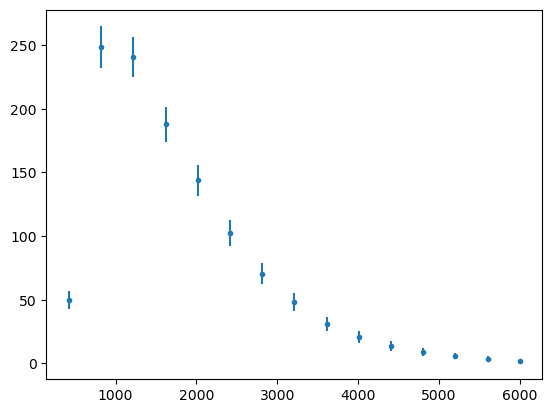

In [4]:
plt.errorbar(Enu,pred,yerr = np.sqrt(sig_tot),fmt = '.')
plt.show()

In [5]:
# Read fk table and construct the x alpha grid
x_alpha, fk_table = get_fk_table(filename = 'fk_table_15')
fk_table = torch.tensor(fk_table, dtype=torch.float32)


x_alpha_tens = torch.tensor(x_alpha, dtype=torch.float32)


/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/read_fk_table.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


In [6]:
# Read fk table and construct the x alpha grid
x_alpha_more_bins, fk_table_more_bins = get_fk_table(filename = 'fk_table_100')
fk_table_more_bins = torch.tensor(fk_table_more_bins, dtype=torch.float32)

x_fit = np.linspace(25,6000,101)
x_fit  = x_fit[1:]


x_alpha_tens_more_bins = torch.tensor(x_alpha_more_bins, dtype=torch.float32)


/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/read_fk_table.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


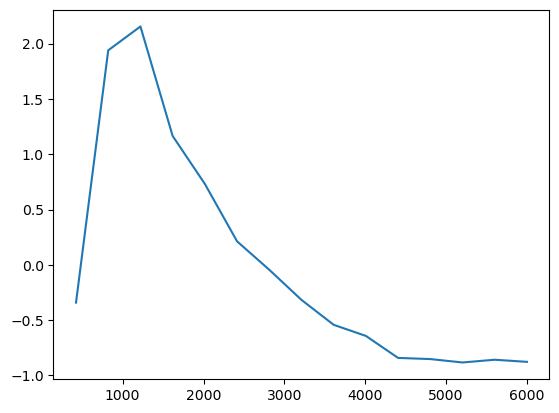

In [7]:
# generate MC replicas using level 2 closure fit

r_sys = np.random.normal(0,sig_sys)
r_stat = np.random.normal(0,np.sqrt(pred))

replicas  = 2
MC_data,MC_data_means,MC_data_stds = [],[],[]
pred_level1 = pred + r_sys + r_stat

for _ in range(replicas):
    r_sys = np.random.normal(0,sig_sys)
    r_stat = np.random.normal(0,np.sqrt(pred))

    pred_level2 = pred_level1 + r_sys + r_stat

    pred_level2_mean, pred_level2_std = pred_level2.mean(), pred_level2.std()
    pred_level2 = (pred_level2 - pred_level2_mean) / pred_level2_std    

    pred_level2 = torch.tensor(pred_level2, dtype=torch.float32).view(-1, 1)
    
    MC_data.append(pred_level2)
    MC_data_means.append(pred_level2_mean)
    MC_data_stds.append(pred_level2_std)

plt.plot(Enu,pred_level2)
plt.show()

In [8]:
class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,l2)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,1)
        self.relu = torch.nn.ReLU()

    def forward(self, y,fk_table,num_bins):
        y = self.linear(y)
        y = self.relu(y)
        y = self.hidden(y)
        y = self.relu(y)
        y = self.hidden2(y)
        y = self.relu(y)
        y = self.hidden3(y)
        # y = torch.einsum('ij,ij->i',  fk_table,y).view(num_bins, 1)
        y = torch.matmul(fk_table,y)

        return y

In [9]:
import torch.nn as nn
class CustomPreprocessing(nn.Module):
    def __init__(self, alpha,beta,gamma):
        super(CustomPreprocessing, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
        self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
        self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))

    def forward(self, x):
        # Ensure x values are within valid range (0 < x < 1)
        x = torch.clamp(x, 1e-6, 1 - 1e-6)  # Avoid division by zero or log errors
        return self.gamma*(1 - x) ** self.beta * x ** (1 - self.alpha)

In [10]:
# Combine the preprocessing and MLP in a single model
class PreprocessedMLP(nn.Module):
    def __init__(self, alpha, beta, gamma,l1, l2, l3):
        super(PreprocessedMLP, self).__init__()
        self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
        self.mlp = SimplePerceptron(l1, l2, l3)

    def forward(self, x,fk_table,num_bins):
        x = self.preprocessing(x)
        x = self.mlp(x,fk_table,num_bins)
        return x

In [11]:
fits = []
data = []
# model = SimplePerceptron(64,128,512,1014,512,128,64)

for i in range(replicas):
    num_bins = init_bins
    # Instantiate the model
    alpha = 0.5  # Example alpha value
    beta = 2.0   # Example beta value
    gamma = 10
    l1=8
    l2=20
    l3=8

    model = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)

    # Loss and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    pred_stoch = MC_data[i].clone()  # Keeps the original intact
    MC_data[i] = MC_data[i].flatten().numpy()
    

    model.train()

    nepochs = 900 # numer of epoches, i.e. times we iterate through the entire dataset

    for epoch in range(nepochs):
        # It is important to shuffle the dataset at each epoch so that the batches are not always the same
        optimizer.zero_grad()

        y_pred = model(x_alpha_tens,fk_table,num_bins)  # Use all data directly
        loss = criterion(y_pred, pred_stoch)

        loss.backward()
        optimizer.step()


    fit = model(x_alpha_tens,fk_table,num_bins)
    fit = fit.detach().flatten().numpy()
    fit = fit* MC_data_stds[i] + MC_data_means[i]
    MC_data[i] = MC_data[i]* MC_data_stds[i] + MC_data_means[i]
    
    red_chi_square_level2 = 1/pred_stoch.size(0) * np.dot(fit - MC_data[i],np.matmul(cov_matrix, fit - MC_data[i]))
    red_chi_square_level1 = 1/pred_stoch.size(0) * np.dot(fit - pred_level1,np.matmul(cov_matrix, fit - pred_level1))

    print(f"reduced chi^2 level 2 = {red_chi_square_level2}")
    print(f"reduced chi^2 level 1 = {red_chi_square_level1}")
    # red_chi_square = 1/pred_stoch.size(0) * np.sum((fit - MC_data[i])**2)
    # print(f"reduced chi^2 = {red_chi_square}")

    # print(f"Constrained alpha: {model.preprocessing.alpha.item()}")
    # print(f"Constrained beta: {model.preprocessing.beta.item()}")

    if red_chi_square_level2 <50:
    
        num_bins = x_alpha_tens_more_bins.size(0)
        y_pred = model(x_alpha_tens_more_bins,fk_table_more_bins,num_bins)
        # y_pred = model(x_alpha_tens,fk_table,num_bins)
        y_pred = y_pred.detach().numpy()
        y_pred = y_pred.flatten()

        y_pred = y_pred * MC_data_stds[i] + MC_data_means[i]
        fits.append(y_pred)
        

reduced chi^2 level 2 = 36.71507194137197
reduced chi^2 level 1 = 35.511269384209164
reduced chi^2 level 2 = 34.36315331813212
reduced chi^2 level 1 = 35.86446476607681


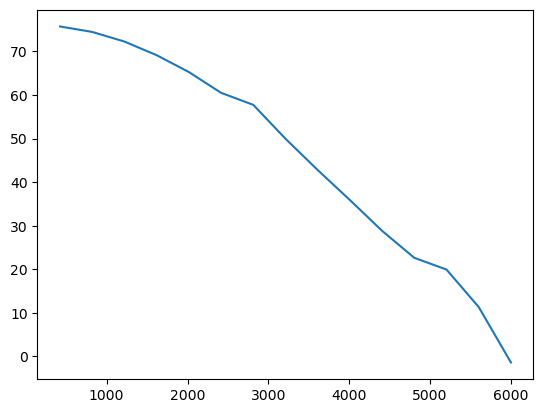

In [12]:
plt.plot(Enu,fit)
plt.show()

In [13]:
mean_fit = np.mean(fits,axis=0)

In [14]:
Enu = Enu.detach().numpy()
Enu = Enu.flatten()

In [15]:
MC_mean = np.mean(MC_data,axis=0)
MC_mean = np.array(MC_mean).flatten()

In [16]:
sigma_fit = np.std(fits,axis=0)
sigma_fit = sigma_fit.flatten()

In [17]:
sigma_data = np.sqrt(sig_tot)

In [18]:
x_fit  = x_fit.flatten()

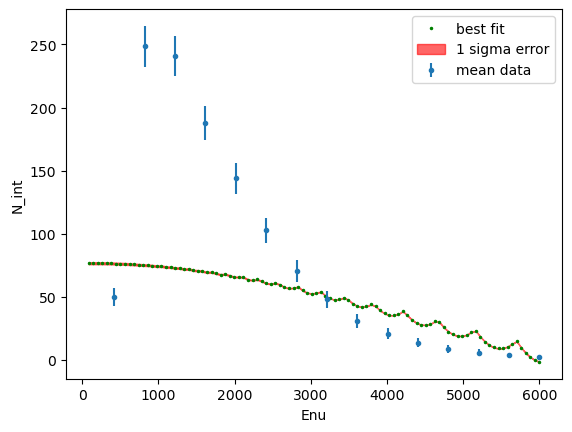

In [19]:

plt.plot(x_fit,mean_fit,'go',label='best fit',markersize=1.5)
plt.fill_between(x_fit,mean_fit+sigma_fit,mean_fit-sigma_fit,label='1 sigma error',color = 'red',alpha=0.6)
# plt.plot(Enu,mean_fit,'go',label='best fit',markersize=1.5)
# plt.fill_between(Enu,mean_fit+sigma_fit,mean_fit-sigma_fit,label='1 sigma error',color = 'red',alpha=0.6)
plt.errorbar(Enu,pred,yerr = sigma_data,label = 'mean data',fmt = '.')
plt.xlabel('Enu')
plt.ylabel('N_int')
plt.legend()    

# plt.savefig('level_2_ML_fit.pdf')
plt.show()

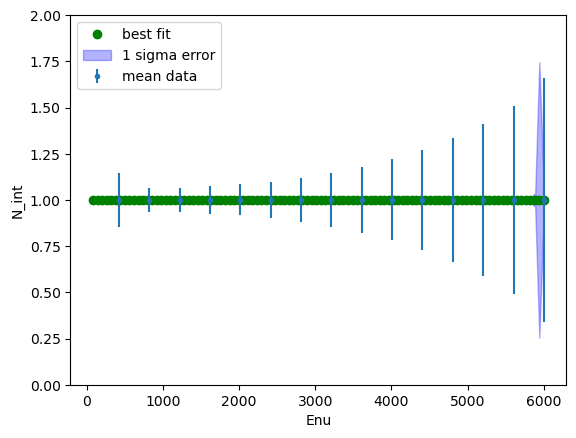

In [20]:
# This plot is to see the relative error of the ML fit
plt.plot(x_fit,mean_fit/mean_fit,'go',label='best fit')
plt.fill_between(x_fit,(mean_fit+sigma_fit)/mean_fit,(mean_fit-sigma_fit)/mean_fit,label='1 sigma error',color = 'blue',alpha=0.3)

# plt.plot(Enu,mean_fit/mean_fit,'go',label='best fit')
# plt.fill_between(Enu,(mean_fit+sigma_fit)/mean_fit,(mean_fit-sigma_fit)/mean_fit,label='1 sigma error',color = 'blue',alpha=0.3)

plt.errorbar(Enu,pred/pred,yerr = sigma_data/pred,label = 'mean data',fmt = '.')


plt.xlabel('Enu')
plt.ylabel('N_int')
plt.legend()
plt.ylim(0,2)
plt.show()